#### Reproduction de figures et valeurs pour :
- Figure N°4 - Matrice de confusion 
- Tableau N°2 - Colonne DINOv2

/share/home/lelain/.conda/envs/gretsienv/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Prédictions sur le test...


100%|██████████| 1774/1774 [00:48<00:00, 36.74it/s]


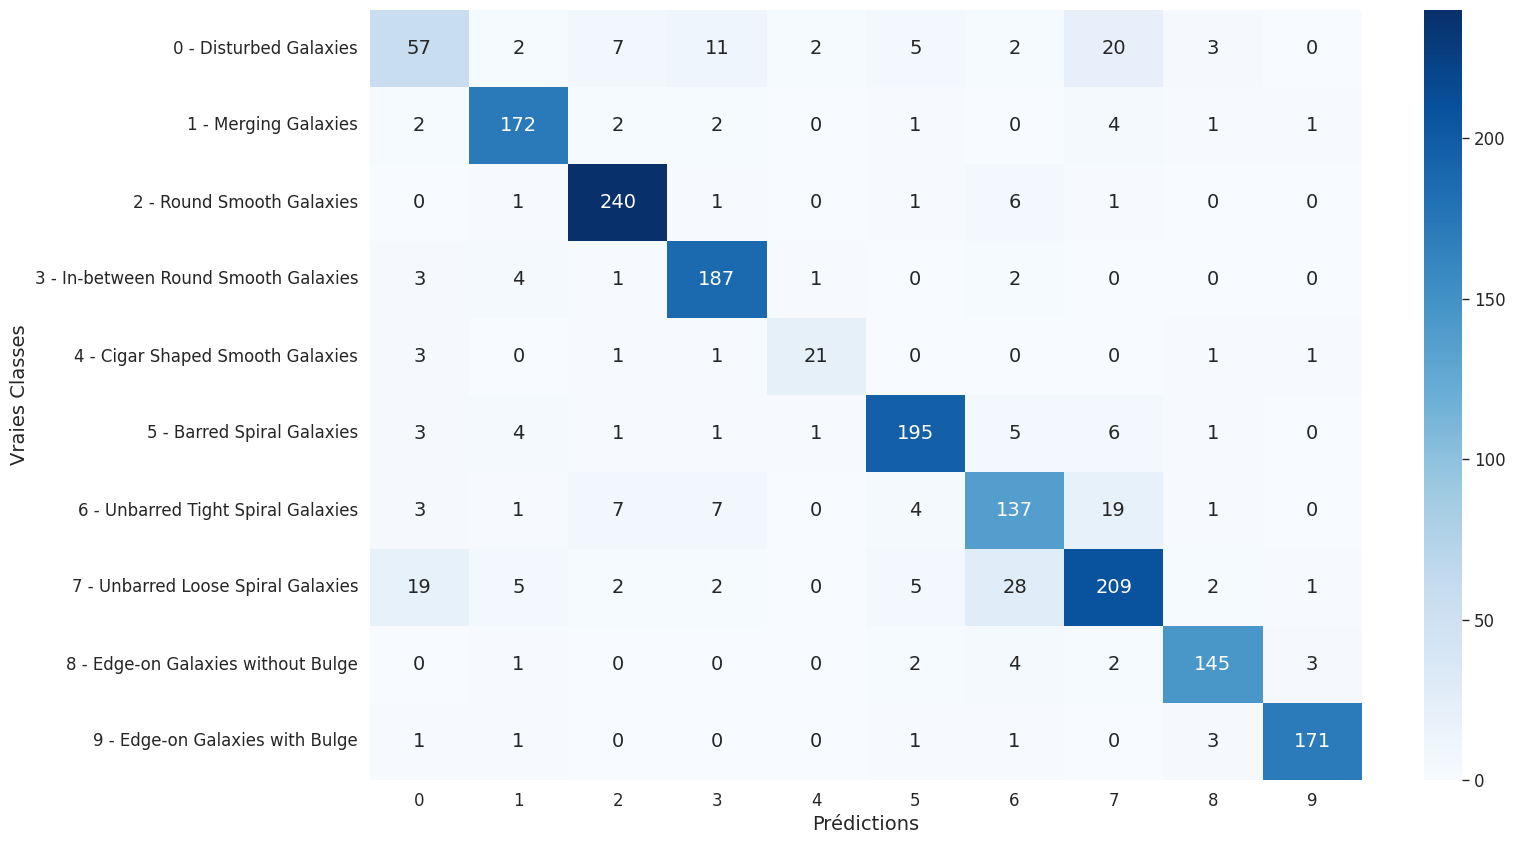

Tableau 2 Colonne DINOv2 (F1-Score):

Disturbed Galaxies: 0.57
Merging Galaxies: 0.91
Round Smooth Galaxies: 0.94
In-between Round Smooth Galaxies: 0.91
Cigar Shaped Smooth Galaxies: 0.79
Barred Spiral Galaxies: 0.90
Unbarred Tight Spiral Galaxies: 0.75
Unbarred Loose Spiral Galaxies: 0.78
Edge-on Galaxies without Bulge: 0.92
Edge-on Galaxies with Bulge: 0.96


In [5]:
# Imports
from transformers import AutoImageProcessor, AutoModelForImageClassification
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

# Modèle après spécialisation sur le dataset Galaxy10 DECaLS
pretrained_model_name = "matthieulel/dinov2-base-imagenet1k-1-layer-finetuned-galaxy10-decals"
dataset_name = "matthieulel/galaxy10_decals"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chargement du dataset (split test)
dataset = load_dataset(dataset_name, split="test")

# Chargement du modèle
model = AutoModelForImageClassification.from_pretrained(pretrained_model_name).to(device).eval()
processor = AutoImageProcessor.from_pretrained(pretrained_model_name)

# Classes du dataset
labels = [
    'Disturbed Galaxies',
    'Merging Galaxies',
    'Round Smooth Galaxies',
    'In-between Round Smooth Galaxies',
    'Cigar Shaped Smooth Galaxies',
    'Barred Spiral Galaxies',
    'Unbarred Tight Spiral Galaxies',
    'Unbarred Loose Spiral Galaxies',
    'Edge-on Galaxies without Bulge',
    'Edge-on Galaxies with Bulge'
]

y_true = []
y_pred = []

print("Prédictions sur le test...")
for i in tqdm(range(len(dataset))):
    image = dataset[i]['image'].convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()

    y_true.append(dataset[i]['label'])
    y_pred.append(pred)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Mode "paper" de Seaborn
sns.set_context("paper")
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 14,            
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.figsize": (6, 4)
})


# Plot
plt.figure(figsize=(16, 10))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=range(len(labels)),  # Numéros de classes en abscisse pour meilleure lisibilité
            yticklabels=[f"{i} - {label}" for i, label in enumerate(labels)])  # Numéros + Noms
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
#plt.title("Matrice de Confusion DINOV2 après spécialisation Galaxy10DECaLS")
plt.savefig("figures/matrice_Figure4.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

# Récupération des metrics et extraction des F1 Scores
report =classification_report(y_true, y_pred, target_names=labels, output_dict=True)
f1_scores = {label: metrics['f1-score'] for label, metrics in report.items() if label not in ['accuracy', 'macro avg', 'weighted avg']}

# Sauvegarde 
print("Tableau 2 Colonne DINOv2 (F1-Score):\n")
with open("figures/tab2_colonneDINOv2.txt", "w") as f:
    f.write("Tableau 2 Colonne DINOv2 (F1-Score):\n")
    for label, f1_score in f1_scores.items():
        f.write(f"{label}: {f1_score:.2f}\n")
        print(f"{label}: {f1_score:.2f}")
